# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import skfuzzy as fuzz
from tqdm.notebook import tqdm
import os
from skfuzzy import cluster


# Data Preprocessing

In [197]:
data = pd.read_csv('data/dataset.csv', index_col=0)
data.drop_duplicates(subset='track_id')
features = ['track_name', 'artists', 'popularity', 'track_genre', 'danceability', 'loudness', 'acousticness', 'valence', 'tempo']
X = data[features].copy()
X.drop_duplicates(subset=['track_name', 'artists'], keep='first', inplace=True)
X.reset_index(drop=True, inplace=True)
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['danceability', 'loudness', 'acousticness', 'valence', 'tempo']])

# Define Model

In [198]:
#Apply Fuzzy C Means clustering
n_clusters = 9  # Number of clusters
m = 2  # Fuzziness parameter


cntr, u, u0,d,jm,p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, n_clusters, m, error=0.005, maxiter=1000, init=None
)

# Visualize Clusters

Since we have 5 features, we use dimensionality reduction such as PCA to project the data into 2D

[0.43656692 0.2696278 ]


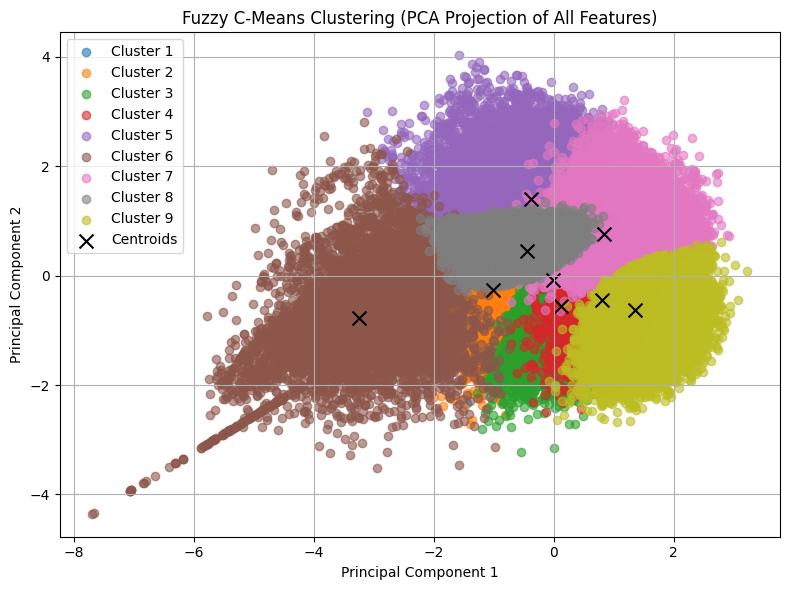

In [199]:
# Reduce all features to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

# Convert fuzzy memberships to hard assignments
cluster_membership = np.argmax(u, axis=0)

# Plot clusters in PCA space
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    cluster_points = X_pca[cluster_membership == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}', alpha=0.6)

# Project and plot cluster centroids
centroids_pca = pca.transform(cntr)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='x', s=100, label='Centroids')

plt.title("Fuzzy C-Means Clustering (PCA Projection of All Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# PCA Based Clustering Information

To visualize the clustering results from the five dimensional features: danceability, loudness, acousticness, valence, and tempo we applied Principal Component Analysis (PCA) to reduce the data to two dimensions.

The first two principal components together explain 65.3% of the total variance in the dataset (40.7% from PC1 and 24.6% from PC2)

This indicate that some information is loss due to dimensionality reduction, but is adequate to show general cluster separation trends


In [200]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

[0.43656692 0.2696278 ]


# Display  Cluster Information

In [201]:
results = X.copy()
results['cluster'] = cluster_membership.astype(str)
print(results['cluster'].value_counts())


cluster
8    12926
6    10685
4    10202
1     9909
2     9465
0     9153
3     7104
7     6571
5     5329
Name: count, dtype: int64


In [202]:
# Make a copy of the data
results = X.copy()

# Add cluster assignments
results['cluster'] = cluster_membership.astype(str)

# Create a DataFrame to store the top 3 genres per cluster
top_genres_list = []

# Loop over each unique cluster
for cluster_id in sorted(results['cluster'].unique(), key=int):
    top_genres = results[results['cluster'] == cluster_id]['track_genre'].value_counts().head(3)
    row = {
        'Cluster': cluster_id,
        'Genre 1': top_genres.index[0] if len(top_genres) > 0 else '',
        'Count 1': top_genres.iloc[0] if len(top_genres) > 0 else 0,
        'Genre 2': top_genres.index[1] if len(top_genres) > 1 else '',
        'Count 2': top_genres.iloc[1] if len(top_genres) > 1 else 0,
        'Genre 3': top_genres.index[2] if len(top_genres) > 2 else '',
        'Count 3': top_genres.iloc[2] if len(top_genres) > 2 else 0,
    }
    top_genres_list.append(row)

# Convert to DataFrame
real_top_genres_df = pd.DataFrame(top_genres_list)
display(real_top_genres_df)

,Cluster,Genre 1,Count 1,Genre 2,Count 2,Genre 3,Count 3
0,0,minimal-techno,567,detroit-techno,406,deep-house,386
1,1,grindcore,532,black-metal,341,death-metal,340
2,2,comedy,322,study,300,tango,205
3,3,chicago-house,284,detroit-techno,201,deep-house,197
4,4,hardstyle,511,drum-and-bass,504,black-metal,476
5,5,sleep,851,new-age,639,ambient,518
6,6,forro,435,pagode,342,j-idol,314
7,7,trance,262,progressive-house,216,cantopop,201
8,8,salsa,530,kids,509,afrobeat,444


# Create Song Search

In [203]:
title = 'shape of you'
artist = ''
X[X['track_name'].str.contains(title, na=False, case=False) & X['artists'].str.contains(artist, na=False, case=False)]

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo
36414,Shape Of You,Andrew Foy,24,guitar,0.561,-15.309,0.791000,0.825,96.893
44142,Shape of You - Abheri - Shudha Dhanyasi - Adi ...,IndianRaga;Mahesh Raghvan;Vinod Krishnan;Adity...,47,indian,0.735,-8.373,0.489000,0.936,95.967
54758,Shape of You - Rock,Our Last Night,48,metalcore,0.554,-4.786,0.000142,0.349,96.005
61250,Shape of You,Ed Sheeran,86,pop,0.825,-3.183,0.581000,0.931,95.977


# Create Playlist Song Recommendation

In [207]:
playlist = [17492] # [3884, 48383, 48625, 50201]
results.iloc[playlist]

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo,cluster
17492,Uptown Funk (feat. Bruno Mars),Mark Ronson;Bruno Mars,83,dance,0.856,-7.223,0.00801,0.928,114.988,8


In [208]:

# Extract the scaled feature vectors and transpose them
X_playlist = X_scaled[playlist].T  # must be (features x samples)

# Predict fuzzy membership for the playlist songs
u_playlist, _, _, _, _,_ = cluster.cmeans_predict(
    test_data=X_playlist,
    cntr_trained= cntr,
    m=m,
    error=0.005,
    maxiter=1000
)

# Convert fuzzy memberships to hard cluster assignments
clusters = np.argmax(u_playlist, axis=0)

# Get the majority cluster
majority = np.bincount(clusters).argmax()

# Get indices of songs in the same cluster
indices = results[results['cluster'] == str(majority)].index

# Compute song_score for each song in the same cluster
song_score = []
for song in indices:
    score = float('inf')
    for liked_song in playlist:
        mse = np.mean((X_scaled[song] - X_scaled[liked_song]) ** 2)
        score = min(score, mse)
    song_score.append(score)

# Select top_k based on playlist length
top_k = len(playlist) + 5
song_score = np.array(song_score)
most_similar = np.argpartition(song_score, top_k)[:top_k]

# Retrieve the recommended songs
recommended_songs = results.iloc[indices[most_similar]]

Display Current Selection

In [209]:
display(recommended_songs)

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo,cluster
17927,Bella,Korede Bello,51,dancehall,0.864,-6.814,0.64200,0.928,114.955,8
1346,Is yeelyel,The Souljazz Orchestra,20,afrobeat,0.843,-7.029,0.04030,0.914,116.002,8
52102,Te Busco,Balbi El Chamako;Adan La Amenaza;Shelo;Luxian;...,41,latino,0.872,-7.532,0.27000,0.913,112.973,8
68433,Sueño Contigo,Guaco,31,salsa,0.850,-7.712,0.47100,0.922,113.910,8
17492,Uptown Funk (feat. Bruno Mars),Mark Ronson;Bruno Mars,83,dance,0.856,-7.223,0.00801,0.928,114.988,8
26559,En el Bar,Miranda!,33,electronic,0.830,-7.185,0.00571,0.947,115.009,8
